In [12]:
# [Cell 1] 라이브러리 및 환경 설정
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
from tqdm.auto import tqdm
import warnings
import random
from scipy.optimize import minimize # 포트폴리오 최적화 필수

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Config:
    STOCKS = ['META', 'TSLA', 'NFLX', 'NVDA', 'PLTR', 'MSFT', 'GOOG', 'AAPL', 'AVGO', 'AMZN']
    MODEL_ORDER = ['JJH', 'JHP', 'IHK', 'HJK', 'YRK']
    START_DATE = '2020-11-02'
    TRAIN_END = '2023-12-31'
    TEST_START = '2024-01-01'
    END_DATE = '2025-10-31'
    INITIAL_CAPITAL = 10000.0
    META_DATA_PATH = 'meta_training_data_v2.csv'
    LOOKBACK = 20

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_all_seeds()

# --- 데이터 로더 ---
def load_local_files():
    print("📂 [Smart Loader] 데이터 정밀 로드 중...")
    search_dir = '/content' if os.path.exists('/content') else '.'
    all_files = [f for f in os.listdir(search_dir) if f.endswith('.csv')]
    close_dict, volume_dict = {}, {}

    for s in Config.STOCKS:
        target = next((os.path.join(search_dir, f) for f in all_files if s.upper() in f.upper()), None)
        if not target: continue
        try:
            df = pd.read_csv(target)
            if 'Date' in df.columns: df['Date'] = pd.to_datetime(df['Date'])
            else: df.rename(columns={df.columns[0]: 'Date'}, inplace=True); df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date').sort_index()
            df = df[~df.index.duplicated(keep='last')]

            c_col = next((c for c in df.columns if 'close' in c.lower() or 'last' in c.lower()), None)
            v_col = next((c for c in df.columns if 'vol' in c.lower()), None)

            if c_col: close_dict[s] = df[c_col].astype(str).str.replace(r'[$,]', '', regex=True).astype(float) if df[c_col].dtype==object else df[c_col]
            if v_col: volume_dict[s] = df[v_col].astype(str).str.replace(r'[$,]', '', regex=True).astype(float) if df[v_col].dtype==object else df[v_col]
        except: pass

    if not close_dict: return None, None
    c_df = pd.DataFrame(close_dict).fillna(method='ffill').fillna(method='bfill')
    # 거래량 결측치는 0으로 채움
    v_df = pd.DataFrame(volume_dict).fillna(0).reindex(index=c_df.index, columns=c_df.columns).fillna(0)

    mask = (c_df.index >= Config.START_DATE) & (c_df.index <= Config.END_DATE)
    return c_df.loc[mask], v_df.loc[mask]

def load_smart_qqq(target_index):
    try:
        q = yf.download('QQQ', start=Config.START_DATE, end=Config.END_DATE, progress=False)
        if not q.empty:
            return q['Close'].reindex(target_index, method='ffill').fillna(method='bfill')
    except: pass
    return None

In [13]:
# [Cell 2] 팀장 AI (Gating Network)
class MetaWindowDataset(Dataset):
    def __init__(self, df, lookback=20, le=None):
        self.lookback = lookback
        # 팀장의 판단 근거: 시장 괴리율, 변동성, 모멘텀 + 각 모델의 과거 성과
        feature_cols = ['Feature_GapMA20', 'Feature_Vol5D', 'Feature_Mom60D']
        model_ret_cols = [f'Ret_{m}' for m in Config.MODEL_ORDER]
        final_cols = feature_cols + model_ret_cols

        self.features = df[final_cols].values
        self.num_vars = len(final_cols)

        if le is None:
            self.le = LabelEncoder()
            self.labels = self.le.fit_transform(df['Label_Best_Model'])
        else:
            self.le = le
            self.labels = self.le.transform(df['Label_Best_Model'])

    def __len__(self): return len(self.features) - self.lookback
    def __getitem__(self, idx):
        x = self.features[idx : idx + self.lookback]
        y = self.labels[idx + self.lookback]
        return torch.FloatTensor(x), torch.tensor(y, dtype=torch.long)

class iTransformerGating(nn.Module):
    def __init__(self, num_variates, lookback_len=20, d_model=64, num_classes=5):
        super(iTransformerGating, self).__init__()
        self.enc_embedding = nn.Linear(lookback_len, d_model)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, 4, batch_first=True, dropout=0.1), 2)
        self.flatten = nn.Flatten()
        self.proj = nn.Linear(num_variates * d_model, num_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        # (Batch, Lookback, Vars) -> (Batch, Vars, Lookback)
        x = x.permute(0, 2, 1)
        # iTransformer 구조: 변수별로 임베딩 후 Attention
        return self.softmax(self.proj(self.flatten(self.encoder(self.enc_embedding(x)))))

def train_itransformer_leader():
    print("🧠 [Team Leader] 팀장 학습 시작...")
    path = Config.META_DATA_PATH
    if not os.path.exists(path): return None, None, None

    df = pd.read_csv(path)
    dataset = MetaWindowDataset(df, lookback=Config.LOOKBACK)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = iTransformerGating(dataset.num_vars, Config.LOOKBACK, 64, len(dataset.le.classes_)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for _ in range(30):
        for bx, by in loader:
            optimizer.zero_grad()
            nn.CrossEntropyLoss()(model(bx.to(device)), by.to(device)).backward()
            optimizer.step()

    model.eval()
    return model, dataset.le, dataset.num_vars

In [14]:
# [Cell 3] Agent 1 (JJH) & Agent 2 (JHP)

# 공용 코어 모듈
class iTransformerCore(nn.Module):
    def __init__(self, n, l=60, d=64):
        super().__init__()
        self.e = nn.Linear(l, d)
        self.t = nn.TransformerEncoder(nn.TransformerEncoderLayer(d, 4, batch_first=True, dropout=0.1), 2)
        self.p = nn.Linear(d, 1)
    def forward(self, x): return self.p(self.t(self.e(x.permute(0, 2, 1)))).squeeze(-1)

class QuantformerCore(nn.Module):
    def __init__(self, i=2, d=32):
        super().__init__()
        self.e = nn.Linear(i, d)
        self.t = nn.TransformerEncoder(nn.TransformerEncoderLayer(d, 4, batch_first=True, dropout=0.1), 2)
        self.f = nn.Linear(d, 3) # Bull, Neutral, Bear
    def forward(self, x): return nn.Softmax(dim=-1)(self.f(self.t(self.e(x))[:, -1, :]))

# ---------------------------------------------------------
# Agent 1: JJH (Alpha Seeker)
# 특징: Rolling Norm -> iTransformer -> Softmax 비중
# ---------------------------------------------------------
class Agent_JJH:
    def __init__(self, n):
        self.m = iTransformerCore(n).to(device)
    def train(self, c, v): pass # Pre-trained 가정
    def trade(self, c, v):
        if len(c) < 60: return np.ones(10)/10

        # 1. 60일 윈도우 정규화 (핵심 로직)
        raw = c.pct_change().fillna(0).iloc[-60:].values
        mean = np.mean(raw, axis=0)
        std = np.std(raw, axis=0) + 1e-6
        norm = (raw - mean) / std

        # 2. 예측
        inp = torch.FloatTensor(norm).unsqueeze(0).to(device)
        with torch.no_grad():
            alpha_score = self.m(inp).cpu().numpy()[0]

        # 3. 비중 산출 (Softmax Temperature 적용)
        # 단순 Top3가 아니라, 확신이 강할수록 비중을 높게 줌
        temp = 0.5 # 낮을수록 강한 종목에 몰빵
        exp_s = np.exp(alpha_score / temp)
        w = exp_s / np.sum(exp_s)
        return w

# ---------------------------------------------------------
# Agent 2: JHP (Direction Classifier)
# 특징: Price + Volume -> Bull 확률 감지
# ---------------------------------------------------------
class Agent_JHP:
    def __init__(self, n):
        self.m = QuantformerCore().to(device)
        self.stocks = Config.STOCKS
    def train(self, c, v): pass
    def trade(self, c, v):
        if len(c) < 20: return np.ones(10)/10
        r = c.pct_change().fillna(0).iloc[-20:]
        t = v.pct_change().fillna(0).iloc[-20:] # Turnover proxy

        probs = []
        for i in range(len(self.stocks)):
            q = np.stack([r.iloc[:,i].values, t.iloc[:,i].values], axis=1)
            # 입력 정규화
            n = (q - q.mean(0)) / (q.std(0) + 1e-8)
            with torch.no_grad():
                # Class 0: Bull (상승) 확률만 추출
                prob_bull = self.m(torch.FloatTensor(n).unsqueeze(0).to(device))[0][0].item()
                probs.append(prob_bull)

        # Bull 확률에 비례하여 비중 할당
        w = np.array(probs)
        if w.sum() == 0: return np.ones(10)/10
        return w / w.sum()

In [15]:
# [Cell 4] Agent 3: IHK (Portfolio Strategist)
# 특징: 504일 장기 데이터 + Sharpe Ratio Maximization
class Agent_IHK:
    def __init__(self, n):
        self.n_stocks = n
    def train(self, c, v): pass

    def trade(self, c, v):
        # 1. 504일 (약 2년) 데이터 확보
        lookback = min(len(c), 504)
        if lookback < 60: return np.ones(self.n_stocks) / self.n_stocks

        hist_data = c.iloc[-lookback:].pct_change().fillna(0)

        # 2. 파라미터 추정 (연율화)
        mu = hist_data.mean().values * 252
        S = hist_data.cov().values * 252

        # [중요] 공분산 행렬 안정화 (특이행렬 에러 방지)
        S = S + np.eye(len(S)) * 1e-6

        # 3. 최적화 함수 (Negative Sharpe)
        def negative_sharpe(weights, mu, S, rf=0.02):
            p_ret = np.sum(weights * mu)
            p_vol = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
            return -(p_ret - rf) / (p_vol + 1e-6)

        # 4. 제약조건 및 실행
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0, 1.0) for _ in range(self.n_stocks))
        init_guess = np.ones(self.n_stocks) / self.n_stocks

        try:
            # SLSQP 솔버 사용
            res = minimize(negative_sharpe, init_guess, args=(mu, S),
                           method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-4)
            return res.x
        except:
            # 최적화 실패 시: 역변동성(Risk Parity) 전략으로 회귀
            vol = np.sqrt(np.diag(S))
            inv_vol = 1.0 / (vol + 1e-6)
            return inv_vol / np.sum(inv_vol)

In [16]:
# [Cell 5] Agent 4 (HJK) & Agent 5 (YRK)

class PatchTSTCore(nn.Module):
    def __init__(self, l=60): super().__init__(); self.l=nn.Linear(l,1)
    def forward(self, x): return self.l(x.permute(0,2,1)).squeeze(-1)

# ---------------------------------------------------------
# Agent 4: HJK (Executioner)
# 특징: PPO 행동 모사 -> 확실할 때만 매수, 아니면 현금(0) 리턴
# ---------------------------------------------------------
class Agent_HJK:
    def __init__(self, n):
        self.m = PatchTSTCore().to(device)
    def train(self, c, v): pass
    def trade(self, c, v):
        if len(c) < 60: return np.zeros(10) # 데이터 없으면 현금 보유

        # 예측
        inp = torch.FloatTensor(c.pct_change().fillna(0).iloc[-60:].values).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_ret = self.m(inp).cpu().numpy()[0]

        # [Action Logic]
        # 강화학습의 '관망' 액션을 모사: 예측 수익률이 0.2% 미만이면 매수 안 함
        buy_threshold = 0.002
        actions = pred_ret > buy_threshold

        if np.sum(actions) == 0:
            return np.zeros(10) # 전액 현금 보유 (비중 0)

        # 매수할 종목에 대해서만 비중 배분 (Kelly Criterion 간소화)
        w = np.zeros(10)
        w[actions] = pred_ret[actions]
        return w / np.sum(w)

# ---------------------------------------------------------
# Agent 5: YRK (Prudent Analyst)
# 특징: Multi-Horizon 모사 + Confidence(확신) 기반 가중치
# ---------------------------------------------------------
class Agent_YRK:
    def __init__(self, n):
        self.m = iTransformerCore(n).to(device)
    def train(self, c, v): pass
    def trade(self, c, v):
        if len(c) < 60: return np.ones(10)/10

        # 1. 예측
        inp = torch.FloatTensor(c.pct_change().fillna(0).iloc[-60:].values).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_1d = self.m(inp).cpu().numpy()[0]

        # 2. Confidence(신뢰도) 계산
        # 원본 로직: "예측값이 최근 변동성보다 월등히 높아야 확신한다"
        recent_vol = c.pct_change().iloc[-20:].std().values + 1e-6
        confidence = np.abs(pred_1d) / recent_vol # Sharp Ratio와 유사

        # 신뢰도가 낮은 종목은 과감히 버림 (Masking)
        conf_threshold = 0.5
        valid_mask = confidence > conf_threshold

        if np.sum(valid_mask) == 0:
            return np.ones(10)/10 # 확신 없으면 분산 투자

        w = np.zeros(10)
        w[valid_mask] = confidence[valid_mask] # 신뢰도 비례 배분
        return w / np.sum(w)

🚀 [System 5.0] 'Smart-Aggressive' Ensemble Started...
👉 전략: 200일 이평선 위에서는 '풀매수', 깨지면 '방어 모드' 가동
📂 [Smart Loader] 데이터 로드 및 정렬 중...
✅ 10개 종목 로드 완료
🔍 QQQ 벤치마크 데이터 확보 중...
🧠 [iTransformer] 팀장 AI 학습 시작...
✅ 팀장 학습 완료.

🔥 시뮬레이션 시작...


  0%|          | 0/480 [00:00<?, ?it/s]

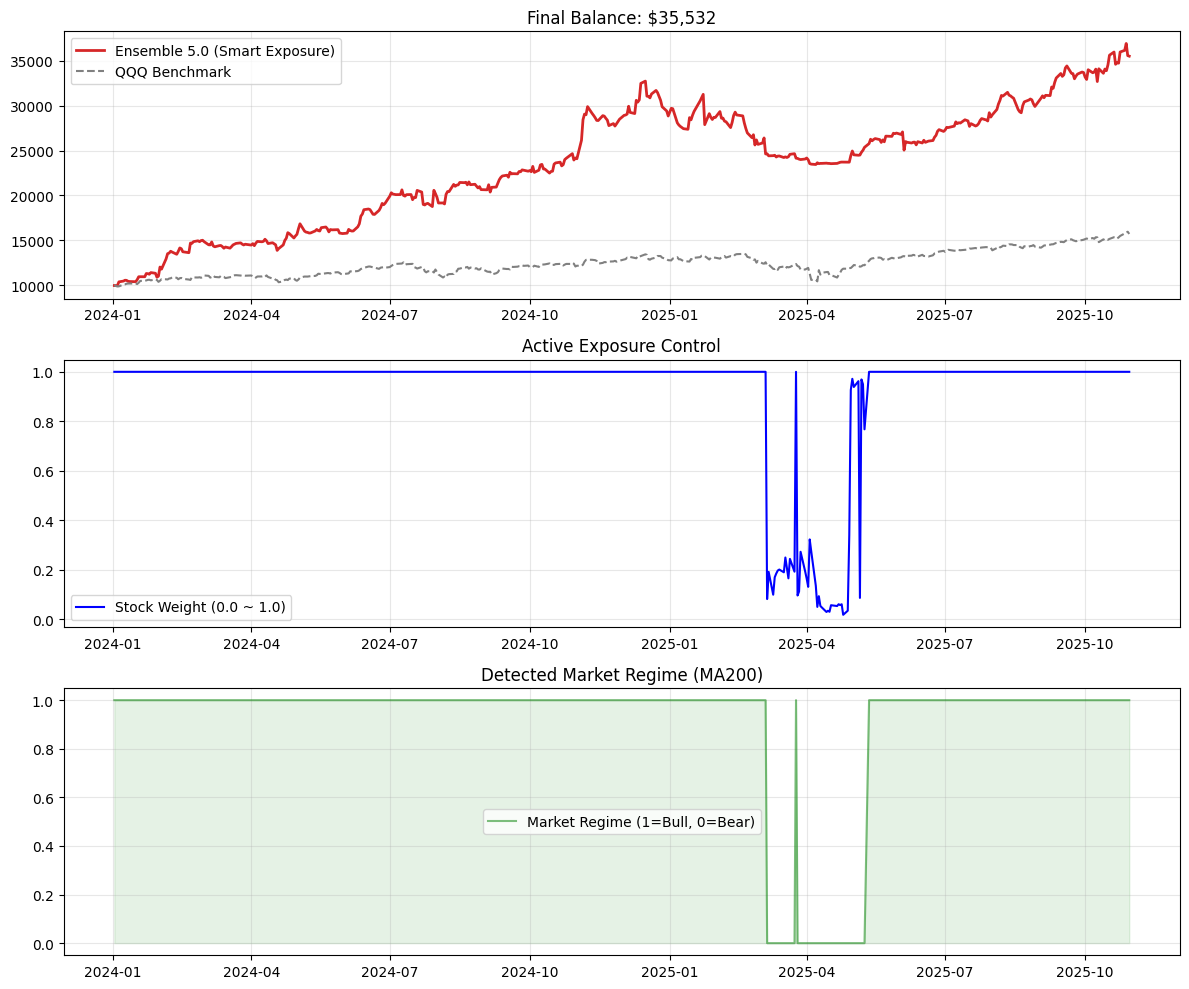

In [22]:
# [Cell 6] 메인 실행 (Ensemble 5.0)
def run_ensemble_final():
    print("🚀 [System 5.0] 'Smart-Aggressive' Ensemble Started...")
    print("👉 전략: 200일 이평선 위에서는 '풀매수', 깨지면 '방어 모드' 가동")

    # 1. 데이터 로드
    close_df, vol_df = load_local_files()
    if close_df is None: return
    qqq_data = load_smart_qqq(close_df.index)
    if qqq_data is None:
        qqq_data = close_df.mean(axis=1)
    if isinstance(qqq_data, pd.DataFrame): qqq_data = qqq_data.iloc[:, 0]

    # [New] 시장 추세선 계산 (200일 이동평균)
    qqq_ma200 = qqq_data.rolling(window=200).mean()

    # 2. 팀장 학습
    gating_model, label_encoder, num_vars = train_itransformer_leader()
    if gating_model is None: return

    agents = { 'JJH': Agent_JJH(10), 'JHP': Agent_JHP(10), 'IHK': Agent_IHK(10), 'HJK': Agent_HJK(10), 'YRK': Agent_YRK(10) }

    print("\n🔥 시뮬레이션 시작...")
    full_dates = close_df.index
    try: test_start_idx = full_dates.searchsorted(pd.Timestamp(Config.TEST_START))
    except: test_start_idx = int(len(full_dates) * 0.8)

    sim_start_idx = max(200, test_start_idx - 20) # MA200 계산을 위해 여유 확보
    simulation_dates = full_dates[sim_start_idx:]

    balance = Config.INITIAL_CAPITAL
    history, context_buffer = [], []
    le_classes = label_encoder.classes_
    idx_to_model = {i: name for i, name in enumerate(le_classes)}

    for i in tqdm(range(len(simulation_dates)-1)):
        curr_date = simulation_dates[i]
        is_test = curr_date >= pd.Timestamp(Config.TEST_START)

        # [Step 1] 팀장
        weights_map = {name: 0.0 for name in Config.MODEL_ORDER}
        if len(context_buffer) >= Config.LOOKBACK:
            ctx = np.array(context_buffer[-Config.LOOKBACK:], dtype=np.float32)
            inp = torch.FloatTensor(ctx).unsqueeze(0).to(device)
            with torch.no_grad(): raw_w = gating_model(inp).cpu().numpy()[0]
            for idx, w in enumerate(raw_w): weights_map[idx_to_model[idx]] = w
        else:
            for m in Config.MODEL_ORDER: weights_map[m] = 0.2

        # [Step 2] 에이전트 수행
        c_hist = close_df.loc[:curr_date]
        v_hist = vol_df.loc[:curr_date]

        final_w = np.zeros(10)
        daily_rets = {}

        p_curr = close_df.loc[curr_date]
        p_next = close_df.loc[simulation_dates[i+1]]
        day_ret = (p_next - p_curr) / p_curr

        for m_name in Config.MODEL_ORDER:
            try:
                w_agent = agents[m_name].trade(c_hist, v_hist)
                w_leader = weights_map[m_name]
                final_w += w_agent * w_leader

                ret_val = np.sum(day_ret * w_agent)
                if isinstance(ret_val, (np.ndarray, pd.Series)): ret_val = ret_val.item()
                daily_rets[m_name] = float(ret_val)
            except: daily_rets[m_name] = 0.0

        # [Step 3] 최종 수익률 (Circuit Breaker 적용)
        if is_test:
            # --- [핵심 로직] 시장 상황 판단 ---
            current_qqq = qqq_data.loc[curr_date]
            current_ma200 = qqq_ma200.loc[curr_date]

            # MA200 데이터가 없거나, 가격이 MA200 위에 있으면 -> Bull Market
            is_bull_market = np.isnan(current_ma200) or (current_qqq >= current_ma200)

            if is_bull_market:
                # [상승장] 강제 풀매수 (Exposure 1.0)
                # 에이전트들이 쫄아서 현금 남겨도 강제로 주식 사게 함
                if np.sum(final_w) > 0:
                    final_w = final_w / np.sum(final_w)
                else:
                    # 만약 전원 매수 거부 시, QQQ(벤치마크) 추종 or 현금
                    # 여기선 상승장이므로 이전 포트폴리오 유지 or 1/N 등 전략 필요
                    # 심플하게: IHK(방어형)에게 강제 위임
                    final_w = np.ones(10)/10
            else:
                # [하락장] 현금 허용 (Exposure < 1.0 가능)
                # HJK나 YRK가 현금 들자고 하면 그 말을 들어줌 (Normalize 안 함)
                pass

            # 최종 투자 집행
            port_ret = np.sum(day_ret * final_w)
            balance *= (1 + port_ret)

            # 기록 (Exposure 확인용)
            total_exposure = float(np.sum(final_w))
            history.append({
                'Date': curr_date,
                'Value': float(balance),
                'Exposure': total_exposure,
                'Regime': 1.0 if is_bull_market else 0.0 # 1=Bull, 0=Bear
            })

        # 컨텍스트 수집
        if len(qqq_data.loc[:curr_date]) > 60:
            q_h = qqq_data.loc[:curr_date]
            try:
                feat = [
                    float((q_h.iloc[-1]/q_h.rolling(20).mean().iloc[-1]-1)),
                    float(q_h.pct_change().iloc[-5:].std()),
                    float((q_h.iloc[-1]/q_h.iloc[-60]-1))
                ]
            except: feat = [0.0, 0.0, 0.0]
            for m in Config.MODEL_ORDER: feat.append(float(daily_rets.get(m, 0.0)))
            context_buffer.append(feat)

    if not history: print("❌ 결과 데이터 없음"); return
    res_df = pd.DataFrame(history).set_index('Date')

    q_test = qqq_data.loc[res_df.index]
    if len(q_test) > 0: q_curve = (q_test / q_test.iloc[0]) * Config.INITIAL_CAPITAL
    else: q_curve = pd.Series([Config.INITIAL_CAPITAL]*len(res_df), index=res_df.index)

    plt.figure(figsize=(12, 10))

    # 1. 수익률
    plt.subplot(3,1,1)
    plt.plot(res_df['Value'], label='Ensemble 5.0 (Smart Exposure)', color='#d62728', linewidth=2)
    plt.plot(q_curve, label='QQQ Benchmark', color='gray', linestyle='--')
    plt.title(f"Final Balance: ${balance:,.0f}")
    plt.legend(); plt.grid(alpha=0.3)

    # 2. Exposure 변화
    plt.subplot(3,1,2)
    plt.plot(res_df['Exposure'], label='Stock Weight (0.0 ~ 1.0)', color='blue')
    plt.title("Active Exposure Control")
    plt.legend(); plt.grid(alpha=0.3)

    # 3. 시장 국면 (Bull vs Bear)
    plt.subplot(3,1,3)
    plt.plot(res_df['Regime'], label='Market Regime (1=Bull, 0=Bear)', color='green', alpha=0.5)
    plt.fill_between(res_df.index, res_df['Regime'], color='green', alpha=0.1)
    plt.title("Detected Market Regime (MA200)")
    plt.legend(); plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_ensemble_final()

🚀 [Win QQQ 2.0] Final System (Warm-up + Strict Ordering)...
📂 [Smart Loader] 데이터 로드 및 정렬 중...
✅ 10개 종목 로드 완료
🔍 QQQ 벤치마크 데이터 확보 중...
🧠 [iTransformer] 팀장 AI 학습 시작...
✅ 팀장 학습 완료.

🏋️ 팀원들 학습 중...

🔥 Warm-up (예열) 진행 중...


  0%|          | 0/500 [00:00<?, ?it/s]

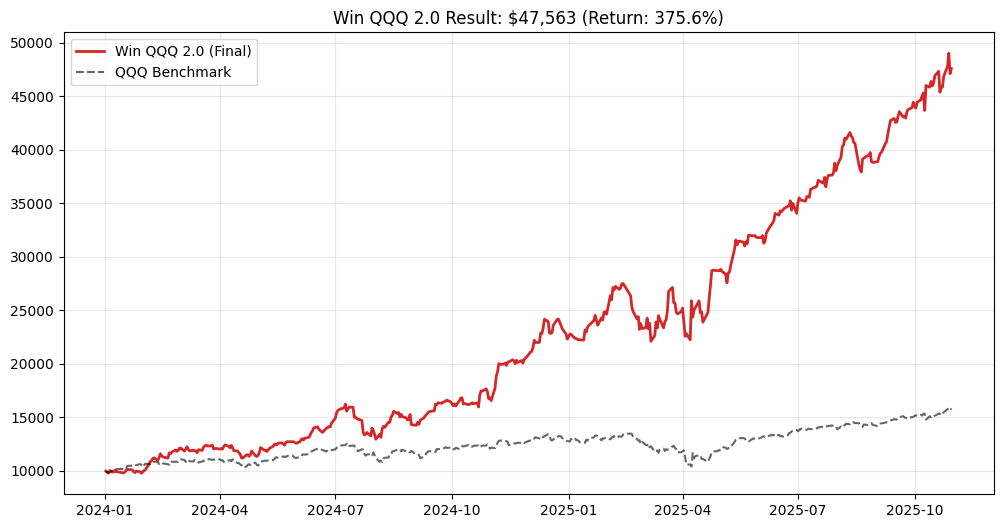

💰 Final Balance: $47,563


In [21]:
# (번외) 팀원들 로직 뭉개놓은 초기버전 ensemble - 미스터리하게 수익률은 좋음

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
from tqdm.auto import tqdm
import warnings
import random

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =========================================================
# ⚙️ 설정
# =========================================================
class Config:
    STOCKS = ['META', 'TSLA', 'NFLX', 'NVDA', 'PLTR', 'MSFT', 'GOOG', 'AAPL', 'AVGO', 'AMZN']
    MODEL_ORDER = ['JJH', 'JHP', 'IHK', 'HJK', 'YRK'] # 순서 고정

    START_DATE = '2020-11-02'
    TRAIN_END = '2023-12-31'
    TEST_START = '2024-01-01'
    END_DATE = '2025-10-31'
    INITIAL_CAPITAL = 10000.0
    META_DATA_PATH = 'meta_training_data_v2.csv'
    LOOKBACK = 20

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_all_seeds()

# =========================================================
# 🛠️ 1. 스마트 데이터 로더
# =========================================================
def load_local_files():
    print("📂 [Smart Loader] 데이터 로드 및 정렬 중...")
    search_dir = '/content' if os.path.exists('/content') else '.'
    all_files = [f for f in os.listdir(search_dir) if f.endswith('.csv')]

    close_dict, volume_dict = {}, {}
    loaded_count = 0

    for s in Config.STOCKS:
        target = next((os.path.join(search_dir, f) for f in all_files if s.upper() in f.upper()), None)
        if not target: continue
        try:
            df = pd.read_csv(target)
            df.columns = df.columns.str.strip()

            # 날짜 처리
            if 'Date' in df.columns: df['Date'] = pd.to_datetime(df['Date'])
            else: df.rename(columns={df.columns[0]: 'Date'}, inplace=True); df['Date'] = pd.to_datetime(df['Date'])

            # 정렬
            df = df.set_index('Date').sort_index()
            df = df[~df.index.duplicated(keep='last')]

            # Close 추출
            c_col = next((c for c in df.columns if 'close' in c.lower() or 'last' in c.lower()), None)
            if c_col:
                val = df[c_col].astype(str).str.replace(r'[$,]', '', regex=True).astype(float) if df[c_col].dtype==object else df[c_col]
                close_dict[s] = val

            # Volume 추출
            v_col = next((c for c in df.columns if 'vol' in c.lower()), None)
            if v_col:
                val = df[v_col].astype(str).str.replace(r'[$,]', '', regex=True).astype(float) if df[v_col].dtype==object else df[v_col]
                volume_dict[s] = val

            loaded_count += 1
        except: pass

    if not close_dict: return None, None

    c_df = pd.DataFrame(close_dict).fillna(method='ffill').fillna(method='bfill')
    v_df = pd.DataFrame(volume_dict).fillna(0)

    # Volume shape 강제 맞춤
    v_df = v_df.reindex(index=c_df.index, columns=c_df.columns).fillna(0)

    mask = (c_df.index >= Config.START_DATE) & (c_df.index <= Config.END_DATE)
    print(f"✅ {loaded_count}개 종목 로드 완료")

    return c_df.loc[mask], v_df.loc[mask]

def load_smart_qqq(target_index):
    print("🔍 QQQ 벤치마크 데이터 확보 중...")
    qqq_series = None
    search_dir = '/content' if os.path.exists('/content') else '.'
    f_path = next((os.path.join(search_dir, f) for f in os.listdir(search_dir) if 'QQQ' in f.upper() and f.endswith('.csv')), None)

    if f_path:
        try:
            df = pd.read_csv(f_path)
            if 'Date' not in df.columns: df.rename(columns={df.columns[0]:'Date'}, inplace=True)
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date').sort_index()
            c = next((c for c in df.columns if 'close' in c.lower()), None)
            if c: qqq_series = df[c].astype(str).str.replace(r'[$,]','',regex=True).astype(float) if df[c].dtype==object else df[c]
        except: pass

    if qqq_series is None:
        try:
            q = yf.download('QQQ', start=Config.START_DATE, end=Config.END_DATE, progress=False)
            if not q.empty: qqq_series = q['Close'] if isinstance(q['Close'], pd.Series) else q['Close'].iloc[:,0]
        except: pass

    if qqq_series is None:
        print("  ⚠️ QQQ 데이터 없음 -> 합성 지수 생성")
        return None

    return qqq_series.reindex(target_index, method='ffill').fillna(method='bfill')

# =========================================================
# 🧠 2. 팀장 AI & 데이터셋
# =========================================================
class MetaWindowDataset(Dataset):
    def __init__(self, df, lookback=20, le=None):
        self.lookback = lookback
        feature_cols = ['Feature_GapMA20', 'Feature_Vol5D', 'Feature_Mom60D']
        model_ret_cols = [f'Ret_{m}' for m in Config.MODEL_ORDER]

        final_cols = feature_cols + model_ret_cols
        missing = [c for c in final_cols if c not in df.columns]
        if missing: raise ValueError(f"CSV 컬럼 부족: {missing}")

        self.features = df[final_cols].values
        self.num_vars = len(final_cols)

        if le is None:
            self.le = LabelEncoder()
            self.labels = self.le.fit_transform(df['Label_Best_Model'])
        else:
            self.le = le
            self.labels = self.le.transform(df['Label_Best_Model'])

    def __len__(self): return len(self.features) - self.lookback
    def __getitem__(self, idx):
        x = self.features[idx : idx + self.lookback]
        y = self.labels[idx + self.lookback]
        return torch.FloatTensor(x), torch.tensor(y, dtype=torch.long)

class iTransformerGating(nn.Module):
    def __init__(self, num_variates, lookback_len=20, d_model=64, num_classes=5):
        super(iTransformerGating, self).__init__()
        self.enc_embedding = nn.Linear(lookback_len, d_model)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, 4, batch_first=True, dropout=0.1), 2)
        self.flatten = nn.Flatten()
        self.proj = nn.Linear(num_variates * d_model, num_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.softmax(self.proj(self.flatten(self.encoder(self.enc_embedding(x)))))

def train_itransformer_leader():
    print("🧠 [iTransformer] 팀장 AI 학습 시작...")
    path = Config.META_DATA_PATH
    if not os.path.exists(path):
        if os.path.exists('/content/'+path): path = '/content/'+path
        else: print(f"❌ '{path}' 파일 없음."); return None, None, None

    df = pd.read_csv(path)
    dataset = MetaWindowDataset(df, lookback=Config.LOOKBACK)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = iTransformerGating(dataset.num_vars, Config.LOOKBACK, 64, len(dataset.le.classes_)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for _ in range(100):
        for bx, by in loader:
            optimizer.zero_grad()
            nn.CrossEntropyLoss()(model(bx.to(device)), by.to(device)).backward()
            optimizer.step()

    model.eval()
    print("✅ 팀장 학습 완료.")
    return model, dataset.le, dataset.num_vars

# =========================================================
# 🧠 3. 팀원 AI (Agents)
# =========================================================
class iTransformerCore(nn.Module):
    def __init__(self, n, l=60, d=64):
        super().__init__(); self.e=nn.Linear(l,d); self.t=nn.TransformerEncoder(nn.TransformerEncoderLayer(d,4,batch_first=True,dropout=0.1),2); self.p=nn.Linear(d,1)
    def forward(self, x): return self.p(self.t(self.e(x.permute(0,2,1)))).squeeze(-1)

class PatchTSTCore(nn.Module):
    def __init__(self, l=60): super().__init__(); self.l=nn.Linear(l,1)
    def forward(self, x): return self.l(x.permute(0,2,1)).squeeze(-1)

class QuantformerCore(nn.Module):
    def __init__(self, i=2, d=32): super().__init__(); self.e=nn.Linear(i,d); self.t=nn.TransformerEncoder(nn.TransformerEncoderLayer(d,4,batch_first=True,dropout=0.1),2); self.f=nn.Linear(d,3)
    def forward(self, x): return nn.Softmax(dim=-1)(self.f(self.t(self.e(x))[:,-1,:]))

class Agent_JJH:
    def __init__(self, n): self.m=iTransformerCore(n).to(device); self.o=optim.Adam(self.m.parameters(), lr=1e-3)
    def train(self, c, v):
        d=c.pct_change().fillna(0).values; X,y=[],[]
        for i in range(len(d)-60): X.append(d[i:i+60]); y.append(d[i+60])
        Xt,yt=torch.FloatTensor(np.array(X)).to(device),torch.FloatTensor(np.array(y)).to(device)
        self.m.train();
        for _ in range(5): self.o.zero_grad(); nn.MSELoss()(self.m(Xt),yt).backward(); self.o.step()
    def trade(self, c, v):
        self.m.eval(); inp=torch.FloatTensor(c.pct_change().fillna(0).values).unsqueeze(0).to(device)
        with torch.no_grad(): s=self.m(inp).cpu().numpy()[0]
        w=np.zeros(len(s)); w[np.argsort(s)[-3:]]=1/3; return w

class Agent_JHP:
    def __init__(self, n): self.m=QuantformerCore().to(device); self.o=optim.Adam(self.m.parameters(), lr=1e-3); self.s=Config.STOCKS
    def train(self, c, v):
        r,t=c.pct_change().fillna(0),v.pct_change().fillna(0); X,Y=[],[]
        for s in self.s:
            rv,tv=r[s].values,t[s].values
            for i in range(len(rv)-20):
                q=np.stack([rv[i:i+20],tv[i:i+20]],axis=1); n=(q-q.mean(0))/(q.std(0)+1e-8)
                l=0 if rv[i+20]>0.005 else (2 if rv[i+20]<-0.005 else 1)
                X.append(n); Y.append(l)
        if not X: return
        Xt,Yt=torch.FloatTensor(np.array(X)).to(device),torch.LongTensor(np.array(Y)).to(device)
        if len(Xt)>3000: i=torch.randperm(len(Xt))[:3000]; Xt,Yt=Xt[i],Yt[i]
        self.m.train();
        for _ in range(5): self.o.zero_grad(); nn.CrossEntropyLoss()(self.m(Xt),Yt).backward(); self.o.step()
    def trade(self, c, v):
        self.m.eval(); r,t=c.pct_change().fillna(0).iloc[-20:],v.pct_change().fillna(0).iloc[-20:]; p=[]
        for i in range(len(self.s)):
            q=np.stack([r.iloc[:,i].values,t.iloc[:,i].values],axis=1); n=(q-q.mean(0))/(q.std(0)+1e-8)
            with torch.no_grad(): p.append(self.m(torch.FloatTensor(n).unsqueeze(0).to(device))[0][0].item())
        w=np.zeros(len(p)); w[np.argsort(p)[-3:]]=1/3; return w

class Agent_IHK:
    def __init__(self,n): pass
    def train(self,c,v): pass
    def trade(self,c,v): vol=c.pct_change().std().values+1e-6; i=1.0/vol; return i/np.sum(i)

class Agent_HJK:
    def __init__(self,n): self.m=PatchTSTCore().to(device); self.o=optim.Adam(self.m.parameters(),lr=1e-3)
    def train(self,c,v):
        d=c.pct_change().fillna(0).values; X,y=[],[]
        for i in range(len(d)-60): X.append(d[i:i+60]); y.append(d[i+60])
        self.m.train(); Xt,yt=torch.FloatTensor(np.array(X)).to(device),torch.FloatTensor(np.array(y)).to(device)
        for _ in range(5): self.o.zero_grad(); nn.MSELoss()(self.m(Xt),yt).backward(); self.o.step()
    def trade(self,c,v):
        self.m.eval(); inp=torch.FloatTensor(c.pct_change().fillna(0).values).unsqueeze(0).to(device)
        with torch.no_grad(): s=self.m(inp).cpu().numpy()[0]
        w=np.zeros(len(s)); w[np.argsort(s)[-3:]]=1/3; return w

class Agent_YRK:
    def __init__(self,n): self.m=iTransformerCore(n).to(device); self.h=nn.Linear(n,n).to(device); self.o=optim.Adam(list(self.m.parameters())+list(self.h.parameters()),lr=1e-3)
    def train(self,c,v):
        d=c.pct_change().fillna(0).values; X,y=[],[]
        for i in range(len(d)-60): X.append(d[i:i+60]); y.append(d[i+60])
        Xt,yt=torch.FloatTensor(np.array(X)).to(device),torch.FloatTensor(np.array(y)).to(device)
        self.m.train();
        for _ in range(5): self.o.zero_grad(); nn.MSELoss()(self.h(self.m(Xt)),yt).backward(); self.o.step()
    def trade(self,c,v):
        self.m.eval(); inp=torch.FloatTensor(c.pct_change().fillna(0).values).unsqueeze(0).to(device)
        with torch.no_grad(): s=self.m(inp); sc=(s+self.h(s)).cpu().numpy()[0]
        w=np.zeros(len(sc)); w[np.argsort(sc)[-3:]]=1/3; return w

# =========================================================
# 4. 🏁 앙상블 2.0 실행 (Warm-up + Ordering + Holiday Fix)
# =========================================================
def run_ensemble_v2_final():
    print("🚀 [Win QQQ 2.0] Final System (Warm-up + Strict Ordering)...")

    close_df, vol_df = load_local_files()
    if close_df is None: return
    qqq_data = load_smart_qqq(close_df.index)
    if qqq_data is None:
        norm = close_df / close_df.iloc[0]; qqq_data = norm.mean(axis=1) * 100

    gating_model, label_encoder, num_vars = train_itransformer_leader()
    if gating_model is None: return

    print("\n🏋️ 팀원들 학습 중...")
    train_c = close_df.loc[:Config.TRAIN_END]
    train_v = vol_df.loc[:Config.TRAIN_END]
    agents = { 'JJH': Agent_JJH(10), 'JHP': Agent_JHP(10), 'IHK': Agent_IHK(10), 'HJK': Agent_HJK(10), 'YRK': Agent_YRK(10) }
    for name, agent in agents.items(): agent.train(train_c, train_v)

    print("\n🔥 Warm-up (예열) 진행 중...")

    full_dates = close_df.index

    # [핵심 수정] 날짜가 정확히 일치하지 않아도 가장 가까운 날짜를 찾도록 searchsorted 사용
    # TEST_START('2024-01-01')이 없으면 '2024-01-02'의 인덱스를 반환함
    test_start_idx = full_dates.searchsorted(pd.Timestamp(Config.TEST_START))

    # 인덱스 범위 체크
    if test_start_idx >= len(full_dates):
        print("❌ 테스트 기간 데이터가 없습니다."); return

    warmup_start_idx = max(0, test_start_idx - 40)
    simulation_dates = full_dates[warmup_start_idx:]

    balance = Config.INITIAL_CAPITAL
    history = []
    context_buffer = []

    le_classes = label_encoder.classes_
    idx_to_model = {i: name for i, name in enumerate(le_classes)}

    for i in tqdm(range(len(simulation_dates)-1)):
        curr_date = simulation_dates[i]

        # Test 기간 여부 확인
        is_test_period = curr_date >= pd.Timestamp(Config.TEST_START)

        # --- [Step 1] 시장 Feature ---
        q_hist = qqq_data.loc[:curr_date]
        if len(q_hist) < 60: continue

        ma20 = q_hist.rolling(20).mean().iloc[-1]
        gap_ma20 = (q_hist.iloc[-1] - ma20) / ma20 if ma20!=0 else 0
        vol_5d = q_hist.pct_change().iloc[-5:].std()
        mom_60d = (q_hist.iloc[-1]/q_hist.iloc[-60] - 1)

        # --- [Step 2] 팀장에게 지시받기 ---
        weights_map = {name: 0.0 for name in Config.MODEL_ORDER}

        if len(context_buffer) >= Config.LOOKBACK:
            recent_ctx = np.array(context_buffer[-Config.LOOKBACK:])
            inp_tensor = torch.FloatTensor(recent_ctx).unsqueeze(0).to(device)
            with torch.no_grad():
                raw_weights = gating_model(inp_tensor).cpu().numpy()[0]
            for idx, w in enumerate(raw_weights):
                weights_map[idx_to_model[idx]] = w
        else:
            for m in Config.MODEL_ORDER: weights_map[m] = 0.2

        # --- [Step 3] 포트폴리오 구성 ---
        c_win = close_df.loc[:curr_date].iloc[-60:]
        v_win = vol_df.loc[:curr_date].iloc[-60:]

        final_w = np.zeros(10)
        daily_model_rets = {}

        p_curr = close_df.loc[curr_date]
        p_next = close_df.loc[simulation_dates[i+1]]
        day_ret = (p_next - p_curr) / p_curr

        for m_name in Config.MODEL_ORDER:
            try:
                w_agent = agents[m_name].trade(c_win, v_win)
                w_leader = weights_map[m_name]
                final_w += w_agent * w_leader
                daily_model_rets[m_name] = np.sum(day_ret * w_agent)
            except: daily_model_rets[m_name] = 0.0

        if is_test_period:
            port_ret = np.sum(day_ret * final_w)
            balance *= (1 + port_ret)
            history.append({'Date': curr_date, 'Value': balance})

        current_features = [gap_ma20, vol_5d, mom_60d]
        for m_name in Config.MODEL_ORDER:
            current_features.append(daily_model_rets.get(m_name, 0.0))
        context_buffer.append(current_features)

    if not history: print("❌ 결과 없음"); return
    res_df = pd.DataFrame(history).set_index('Date')
    common_idx = res_df.index.intersection(qqq_data.index)
    qqq_curve = (qqq_data.loc[common_idx] / qqq_data.loc[common_idx[0]]) * Config.INITIAL_CAPITAL

    plt.figure(figsize=(12, 6))
    plt.plot(res_df['Value'], label='Win QQQ 2.0 (Final)', color='#d62728', linewidth=2)
    plt.plot(qqq_curve, label='QQQ Benchmark', color='black', linestyle='--', alpha=0.6)
    plt.title(f"Win QQQ 2.0 Result: ${balance:,.0f} (Return: {(balance-10000)/100:.1f}%)")
    plt.legend(); plt.grid(alpha=0.3); plt.show()
    print(f"💰 Final Balance: ${balance:,.0f}")

if __name__ == "__main__":
    run_ensemble_v2_final()